In [1]:
import numpy as np
import pandas as pd

import missingno as mno

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

# pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
# function collection

# Outliers Checking
# check the distribution and outlier
def distCheck(data):
    display(data.describe(percentiles=[.05, .25, .5, .75, .95]).astype(int))

    fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(20,10))

    sns.distplot(data, ax=ax[0])
    sns.boxplot(x=data, showmeans=True, ax=ax[1])
    sns.violinplot(x=data, ax=ax[2])

# Check outlier using iqr approach
def boundLim(data, col):
    q1, q3 = data[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lowBound = q1-1.5*iqr
    upBound =  q3+1.5*iqr

    nLow = len(data[data[col] < lowBound])
    nUp = len(data[data[col] > upBound])

    lowOut = nLow/data.shape[0]*100
    upOut = nUp/data.shape[0]*100

    totOut = lowOut + upOut

    summary = f'''
    Hasil pengecekan outlier pada kolom {col}
    
    lower bound : {lowBound}
    upper bound : {upBound}

    jumlah outlier bawah    : {lowOut} %
    jumlah outlier atas     : {upOut} %
    Jumlah semua outlier    : {totOut} %
    '''

    return lowBound, upBound, nLow, nUp, lowOut, upOut, totOut, summary

# `Context`

## Domain Knowledge
* How Airbnb works: https://www.igms.com/airbnb-business-model/#:~:text=The%20Airbnb%20business%20model%20is%20a%20two%2Dsided%20marketplace%20that,property%20owner%20for%20each%20booking.
* The majority of its revenue comes from **service fees from bookings** charged to both guests and hosts (https://www.investopedia.com/articles/investing/112414/how-airbnb-makes-money.asp#:~:text=The%20majority%20of%20its%20revenue,IPO%20at%20%2468%20a%20share.)
* Airbnb service fees (https://www.airbnb.com/help/article/1857):
    * Split Fee
        * Host (3%)
        * Guest (14.2%)
    * Host Only (14–16%)
* Why People travel to Bangkok? Bangkok has attracted millions of visitors annually for decades, offering tourists an incredible experience of cultural tradition-meets-modernity. It’s got world-class food, stunning historical landmarks, and some of the best hospitality around the globe. (https://theculturetrip.com/asia/thailand/articles/11-amazing-reasons-to-visit-bangkok-thailand/)
* Best Things to do in Bangkok: https://www.tripadvisor.com/Attractions-g293916-Activities-Bangkok.html
* Bangkok Lattitude, Longitude : 13.7563° N, 100.5018° E
* AirBNB paling mahal di Thailand: 22,324 USD / 835,632 THB (https://www.smoney.com.au/blog/the-most-expensive-airbnb-in-every-country/)
* The average price of a night in a vacation rental in in Bangkok is $33 / 1,164 THB (https://www.likibu.com/short-term-rental/bangkok)
* kurs USD to THB: 1 USD = 37.432 THB (period: 06/11/2022, https://www.exchangerates.org.uk/USD-THB-06_11_2022-exchange-rate-history.html)
* How's the minimum nights rules in Thailand?
    * by rules non-hotel can't do short term rental (minimum 30 days) (https://www.thethailandlife.com/airbnb-thailand#:~:text=Should%20I%20still%20go%20ahead,you%20stay%20within%20the%20law.)
    * it can be legal if they have received an official exemption from the 2008 Thailand Hotel Act. (https://web.facebook.com/notes/3127419484030843/?_rdc=1&_rdr)
    * 86.2% short-term rentals (below 30 minimum nights) (period checking: 01/07/2023 , http://insideairbnb.com/bangkok/#)
* City Data (https://airbtics.com/airbnb-occupancy-rates-by-city/):
    * Number of Airbnb listings: 14,443
    * Number of VRBO listings: 1,365 
    * Average Occupancy Rate: 23% 
    * Average Nightly Rate: $57 
    * Annual Revenue: $5,328 
    * International Traveller Ratio: 75% 
    * Biggest travellers origin: USA
    * Biggest domestic travellers origin: Bangkok
    * Most common guests language: English 
    * Peak season: February

## Problem
**Add new property which have high-performance characteristics**
* Airbnb want to increase the revenue in Bangkok 
* How to do is add the most potential property
* Because of that, **Airbnb want to Know high-performance property**
* Benefit of this information such as:
    - Decrease cost and time for property searching
    - Improve property listing qualities
    - Help grouping the property
* Question for Data Analyst: 
    - **How's the performance of Airbnb property in Bangkok?**
    - **How's the characteristics of high-performances property?**
    - **How's the recommendation to improve?**

## Stakeholder
* Business Development Manager
* Account Manager

In [3]:
# load main data
bnb = pd.read_csv(r'D:\PURWADHIKA\PLAYGROUND\PYTHON\Modul 2\Capstone\Airbnb-listings-Bangkok\data\raw\Airbnb Listings Bangkok.csv')
bnb.head()

,Unnamed: 0,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
0,0,27934,Nice room with superb city view,120437,Nuttee,Ratchathewi,13.75983,100.54134,Entire home/apt,1905,3,65,2020-01-06,0.50,2,353,0
1,1,27979,"Easy going landlord,easy place",120541,Emy,Bang Na,13.66818,100.61674,Private room,1316,1,0,NaN,NaN,2,358,0
2,2,28745,modern-style apartment in Bangkok,123784,Familyroom,Bang Kapi,13.75232,100.62402,Private room,800,60,0,NaN,NaN,1,365,0
3,3,35780,Spacious one bedroom at The Kris Condo Bldg. 3,153730,Sirilak,Din Daeng,13.78823,100.57256,Private room,1286,7,2,2022-04-01,0.03,1,323,1
4,4,941865,Suite Room 3 at MetroPoint,610315,Kasem,Bang Kapi,13.76872,100.63338,Private room,1905,1,0,NaN,NaN,3,365,0


In [4]:
# load additional data
add = pd.read_csv(r'D:\PURWADHIKA\PLAYGROUND\PYTHON\Modul 2\Capstone\Airbnb-listings-Bangkok\data\raw\additional_data.csv')
add.head()

,id,listing_url,host_response_time,host_response_rate,accommodates,amenities,review_scores_rating,accommodates_type
0,27934,https://www.airbnb.com/rooms/27934,within an hour,100.0,3,"[""Shampoo"", ""Kitchen"", ""Fire extinguisher"", ""F...",4.85,family
1,941865,https://www.airbnb.com/rooms/941865,within an hour,100.0,2,"[""Washer"", ""Air conditioning"", ""Breakfast"", ""K...",NaN,single/couple
2,27979,https://www.airbnb.com/rooms/27979,a few days or more,0.0,2,"[""Pool"", ""Washer"", ""First aid kit"", ""Heating"",...",NaN,single/couple
3,28745,https://www.airbnb.com/rooms/28745,no information,NaN,2,"[""Long term stays allowed""]",NaN,single/couple
4,35780,https://www.airbnb.com/rooms/35780,within an hour,100.0,2,"[""Clothing storage: closet and dresser"", ""Blen...",4.50,single/couple


In [5]:
# merge data
bnb = bnb.merge(add)
bnb.head()

,Unnamed: 0,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,listing_url,host_response_time,host_response_rate,accommodates,amenities,review_scores_rating,accommodates_type
0,0,27934,Nice room with superb city view,120437,Nuttee,Ratchathewi,13.75983,100.54134,Entire home/apt,1905,3,65,2020-01-06,0.50,2,353,0,https://www.airbnb.com/rooms/27934,within an hour,100.0,3,"[""Shampoo"", ""Kitchen"", ""Fire extinguisher"", ""F...",4.85,family
1,1,27979,"Easy going landlord,easy place",120541,Emy,Bang Na,13.66818,100.61674,Private room,1316,1,0,NaN,NaN,2,358,0,https://www.airbnb.com/rooms/27979,a few days or more,0.0,2,"[""Pool"", ""Washer"", ""First aid kit"", ""Heating"",...",NaN,single/couple
2,2,28745,modern-style apartment in Bangkok,123784,Familyroom,Bang Kapi,13.75232,100.62402,Private room,800,60,0,NaN,NaN,1,365,0,https://www.airbnb.com/rooms/28745,no information,NaN,2,"[""Long term stays allowed""]",NaN,single/couple
3,3,35780,Spacious one bedroom at The Kris Condo Bldg. 3,153730,Sirilak,Din Daeng,13.78823,100.57256,Private room,1286,7,2,2022-04-01,0.03,1,323,1,https://www.airbnb.com/rooms/35780,within an hour,100.0,2,"[""Clothing storage: closet and dresser"", ""Blen...",4.50,single/couple
4,4,941865,Suite Room 3 at MetroPoint,610315,Kasem,Bang Kapi,13.76872,100.63338,Private room,1905,1,0,NaN,NaN,3,365,0,https://www.airbnb.com/rooms/941865,within an hour,100.0,2,"[""Washer"", ""Air conditioning"", ""Breakfast"", ""K...",NaN,single/couple


# `Data Understanding & Cleaning`

## Data Understanding

### Shape

In [6]:
# Data Shape
bnb.shape

(15854, 24)

### Data Type

In [7]:
# Data Type (Formatting)
bnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15854 entries, 0 to 15853
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      15854 non-null  int64  
 1   id                              15854 non-null  int64  
 2   name                            15846 non-null  object 
 3   host_id                         15854 non-null  int64  
 4   host_name                       15853 non-null  object 
 5   neighbourhood                   15854 non-null  object 
 6   latitude                        15854 non-null  float64
 7   longitude                       15854 non-null  float64
 8   room_type                       15854 non-null  object 
 9   price                           15854 non-null  int64  
 10  minimum_nights                  15854 non-null  int64  
 11  number_of_reviews               15854 non-null  int64  
 12  last_review                     

### Duplicate Data

In [8]:
# Data Duplicate
bnb.duplicated().sum()

0

### Missing Value & Ambiguity

In [9]:
# Missing values & Data formatting 

pd.DataFrame(
        {
        'feature': bnb.columns.values,
        'null_value': bnb.isna().sum(),        
        '%null_value': bnb.isna().mean().values * 100,
        'n_unique': bnb.nunique().values,
        'sample_unique': [bnb[col].sort_values().unique() for col in bnb.columns]
        }
    )

,feature,null_value,%null_value,n_unique,sample_unique
Unnamed: 0,Unnamed: 0,0,0.000000,15854,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
id,id,0,0.000000,15854,"[27934, 27979, 28745, 35780, 48736, 55681, 556..."
name,name,8,0.050460,14794,[!!!OMG!!/4 mins to Train St./Train Market/火车头...
host_id,host_id,0,0.000000,6659,"[58920, 70413, 108793, 120437, 120541, 121622,..."
host_name,host_name,1,0.006308,5312,"[.● Bm, 1905 Heritage Corner, 1989 Ratchada, 3..."
neighbourhood,neighbourhood,0,0.000000,50,"[Bang Bon, Bang Kapi, Bang Khae, Bang Khen, Ba..."
latitude,latitude,0,0.000000,9606,"[13.5273, 13.60039, 13.6013, 13.60304, 13.6053..."
longitude,longitude,0,0.000000,10224,"[100.32955, 100.32962, 100.33335, 100.33356, 1..."
room_type,room_type,0,0.000000,4,"[Entire home/apt, Hotel room, Private room, Sh..."
price,price,0,0.000000,3040,"[0, 278, 280, 295, 300, 303, 304, 305, 310, 31..."


<Axes: >

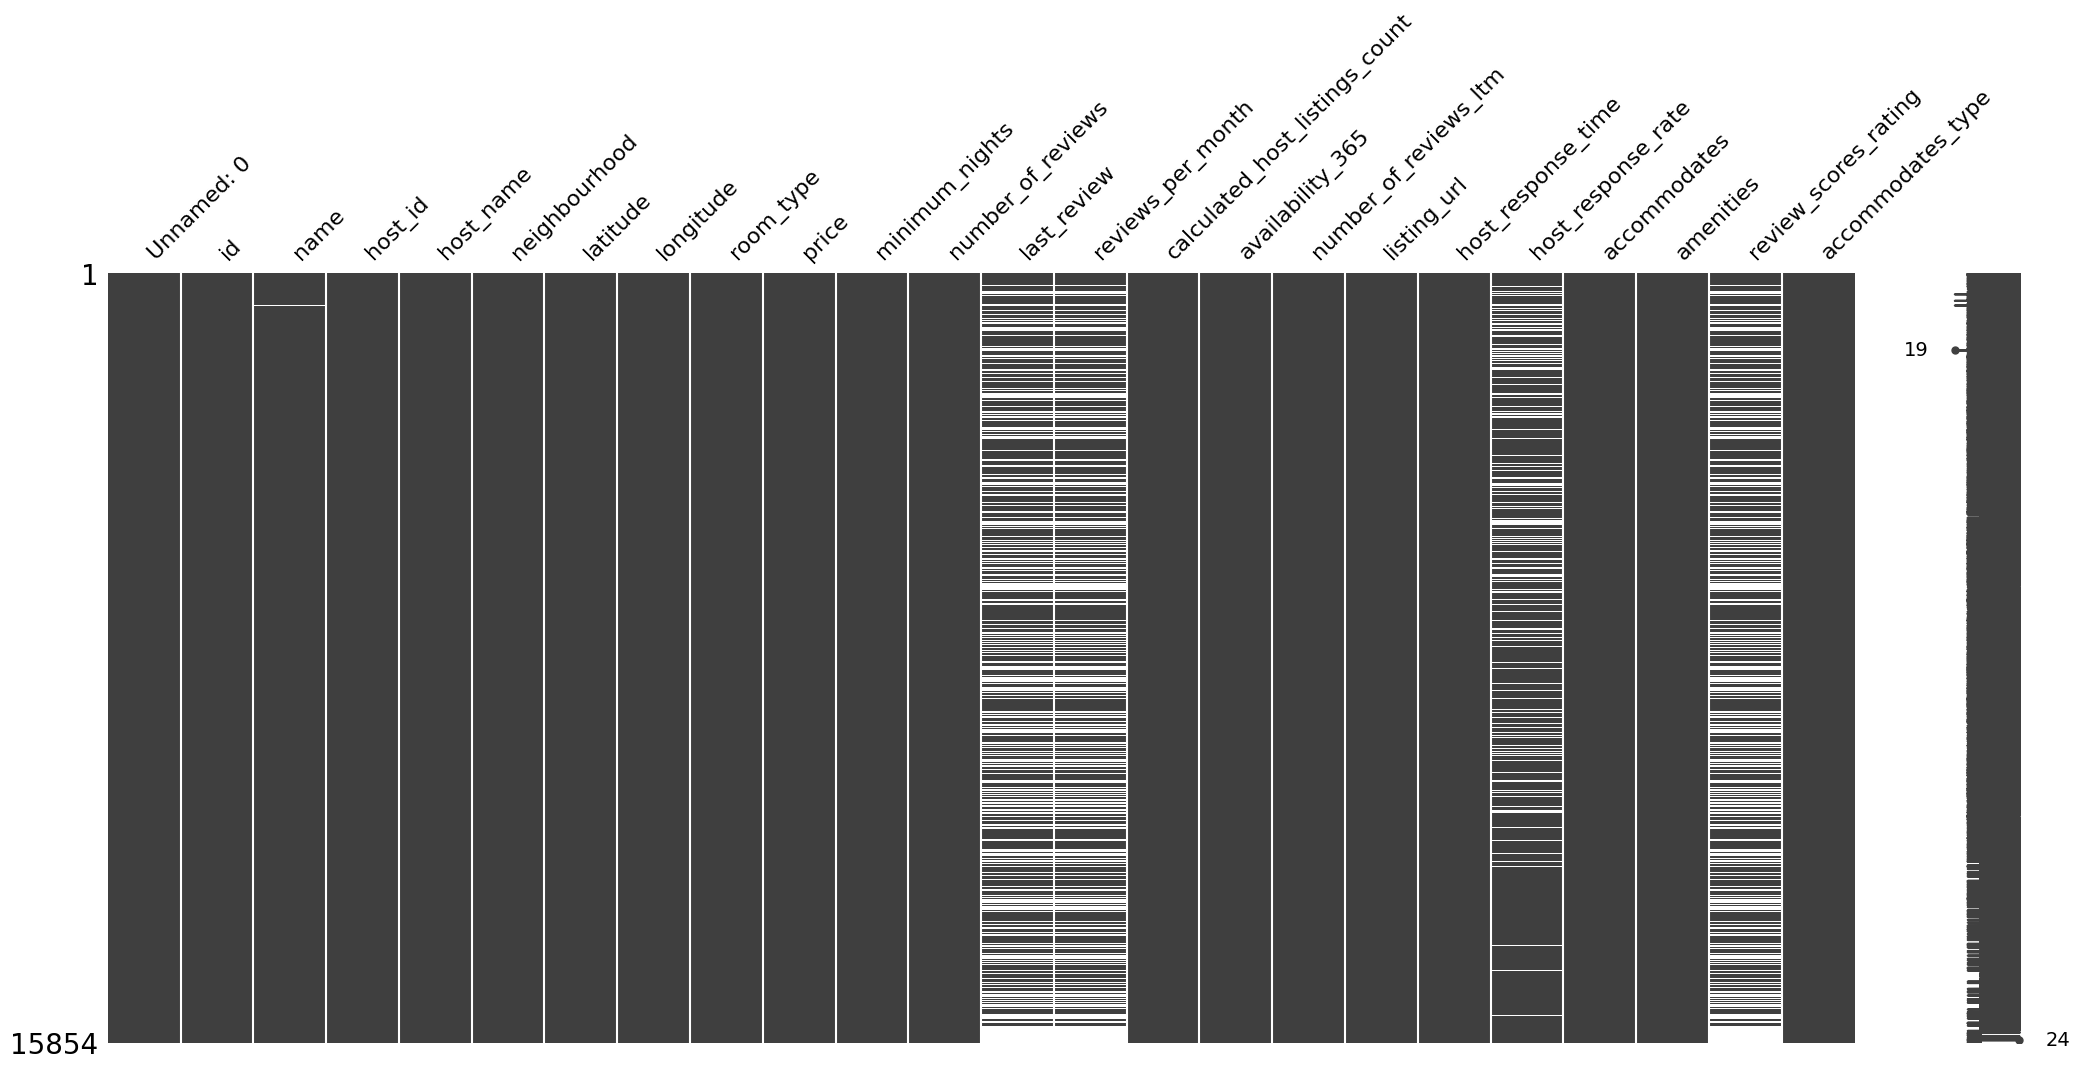

In [10]:
# spread of missing values
mno.matrix(bnb)

### Distribution & Outliers

In [11]:
# Data Description
display(bnb.describe(), bnb.describe(include=object))

,Unnamed: 0,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,host_response_rate,accommodates,review_scores_rating
count,15854.000000,1.585400e+04,1.585400e+04,15854.000000,15854.000000,1.585400e+04,15854.000000,15854.000000,10064.000000,15854.000000,15854.000000,15854.000000,12917.000000,15854.000000,10064.000000
mean,7926.500000,1.579397e+17,1.541058e+08,13.745144,100.559903,3.217704e+03,15.292355,16.654157,0.813145,13.889618,244.378643,3.481519,85.658589,3.061940,4.592629
std,4576.799919,2.946015e+17,1.318726e+08,0.043040,0.050911,2.497212e+04,50.815020,40.613331,1.090196,30.269848,125.843224,8.916937,30.502908,2.133103,0.771802
min,0.000000,2.793400e+04,5.892000e+04,13.527300,100.329550,0.000000e+00,1.000000,0.000000,0.010000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3963.250000,2.104509e+07,3.974431e+07,13.720090,100.529690,9.000000e+02,1.000000,0.000000,0.120000,1.000000,138.000000,0.000000,92.000000,2.000000,4.550000
50%,7926.500000,3.503734e+07,1.224556e+08,13.738490,100.561415,1.429000e+03,1.000000,2.000000,0.435000,4.000000,309.000000,0.000000,100.000000,2.000000,4.800000
75%,11889.750000,5.256154e+07,2.390547e+08,13.759497,100.585150,2.429000e+03,7.000000,13.000000,1.060000,13.000000,360.000000,3.000000,100.000000,4.000000,5.000000
max,15853.000000,7.908162e+17,4.926659e+08,13.953540,100.923440,1.100000e+06,1125.000000,1224.000000,19.130000,228.000000,365.000000,325.000000,100.000000,16.000000,5.000000


,name,host_name,neighbourhood,room_type,last_review,listing_url,host_response_time,amenities,accommodates_type
count,15846,15853,15854,15854,10064,15854,15854,15854,15854
unique,14794,5312,50,4,1669,15854,5,13587,2
top,New! La Chada Night Market studio 2PPL near MRT,Curry,Vadhana,Entire home/apt,2022-12-11,https://www.airbnb.com/rooms/27934,within an hour,"[""Long term stays allowed""]",single/couple
freq,45,228,2153,8912,189,1,8886,62,9553


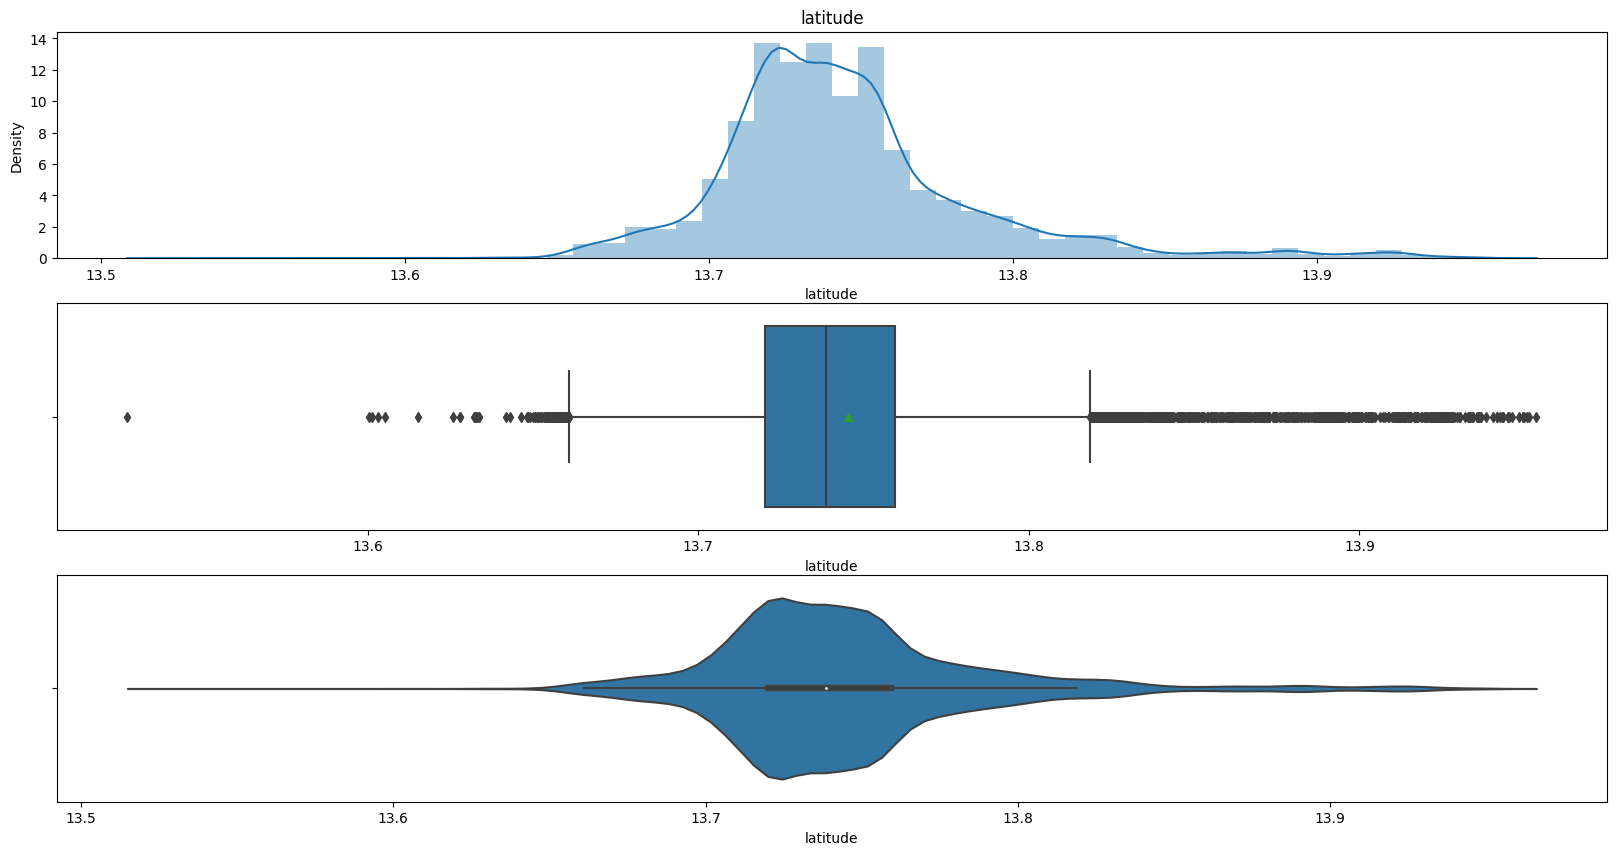

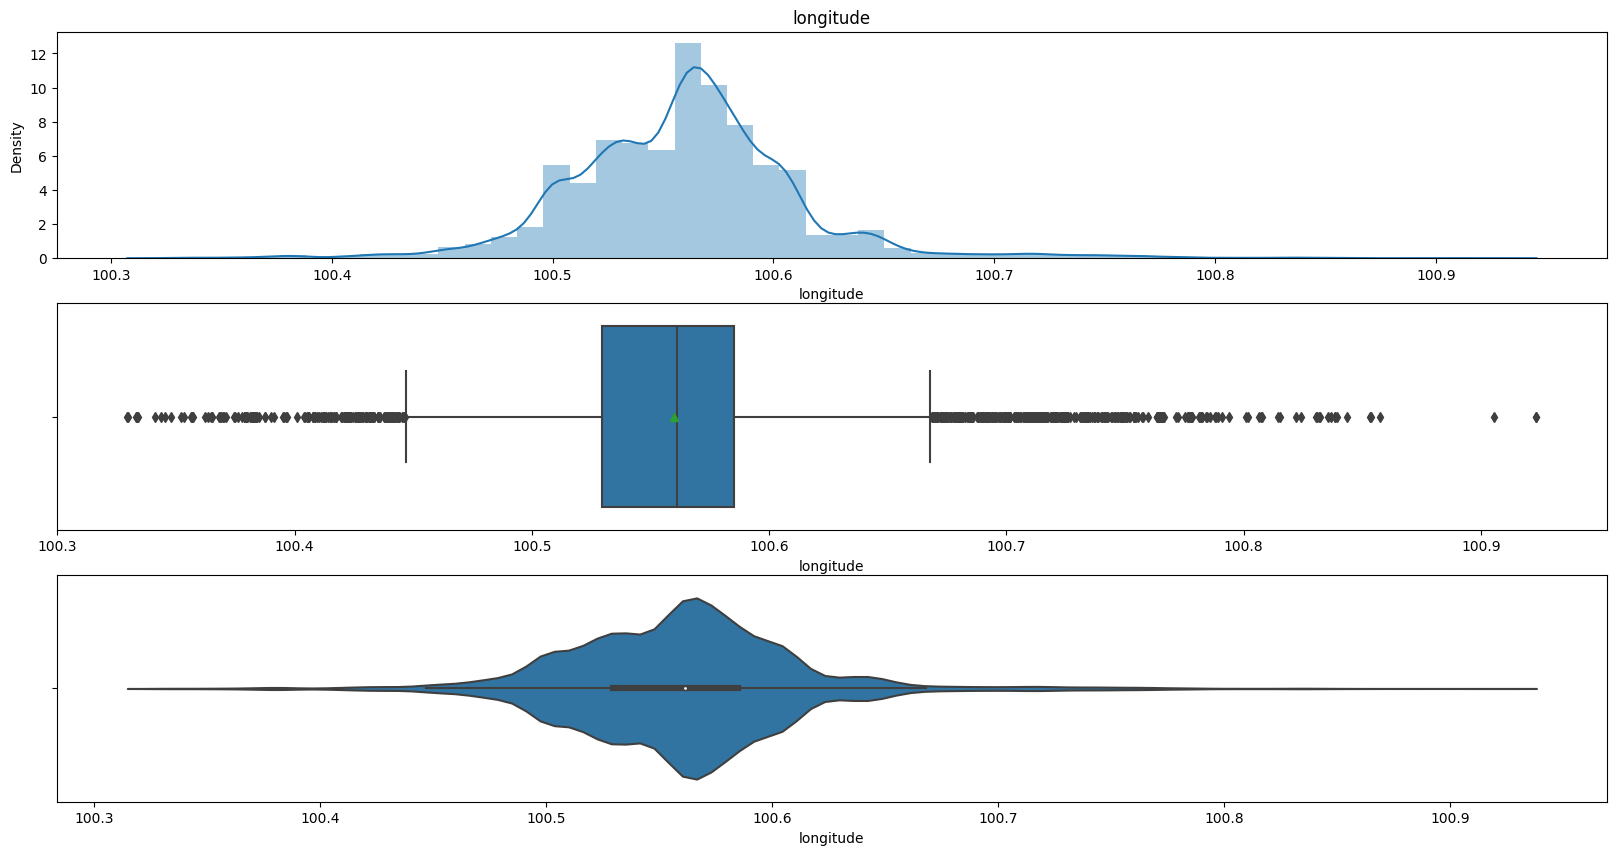

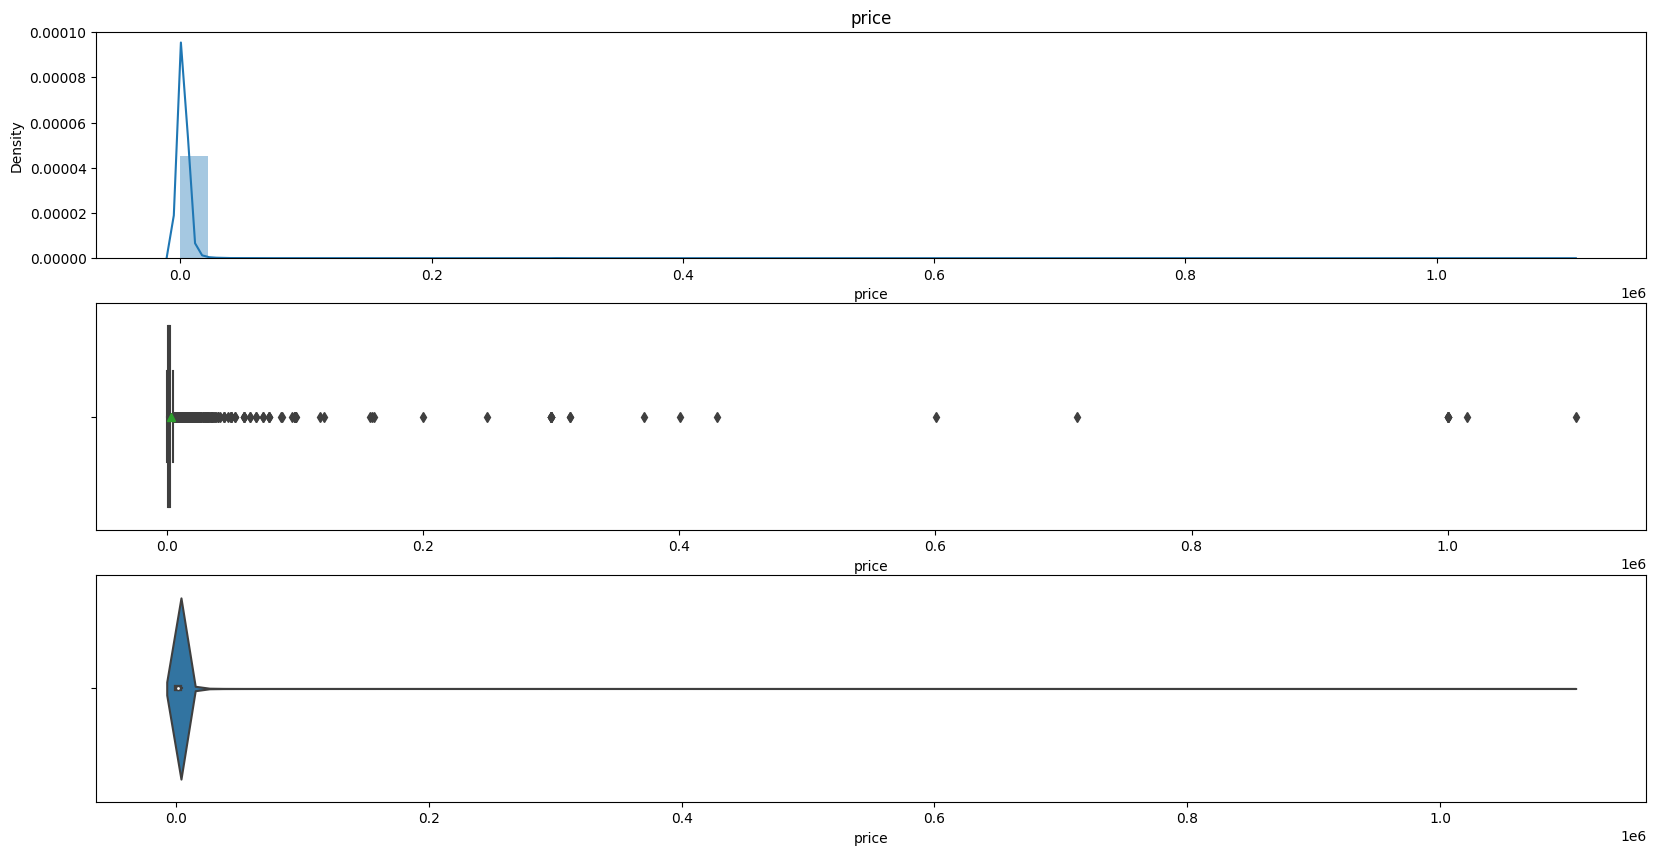

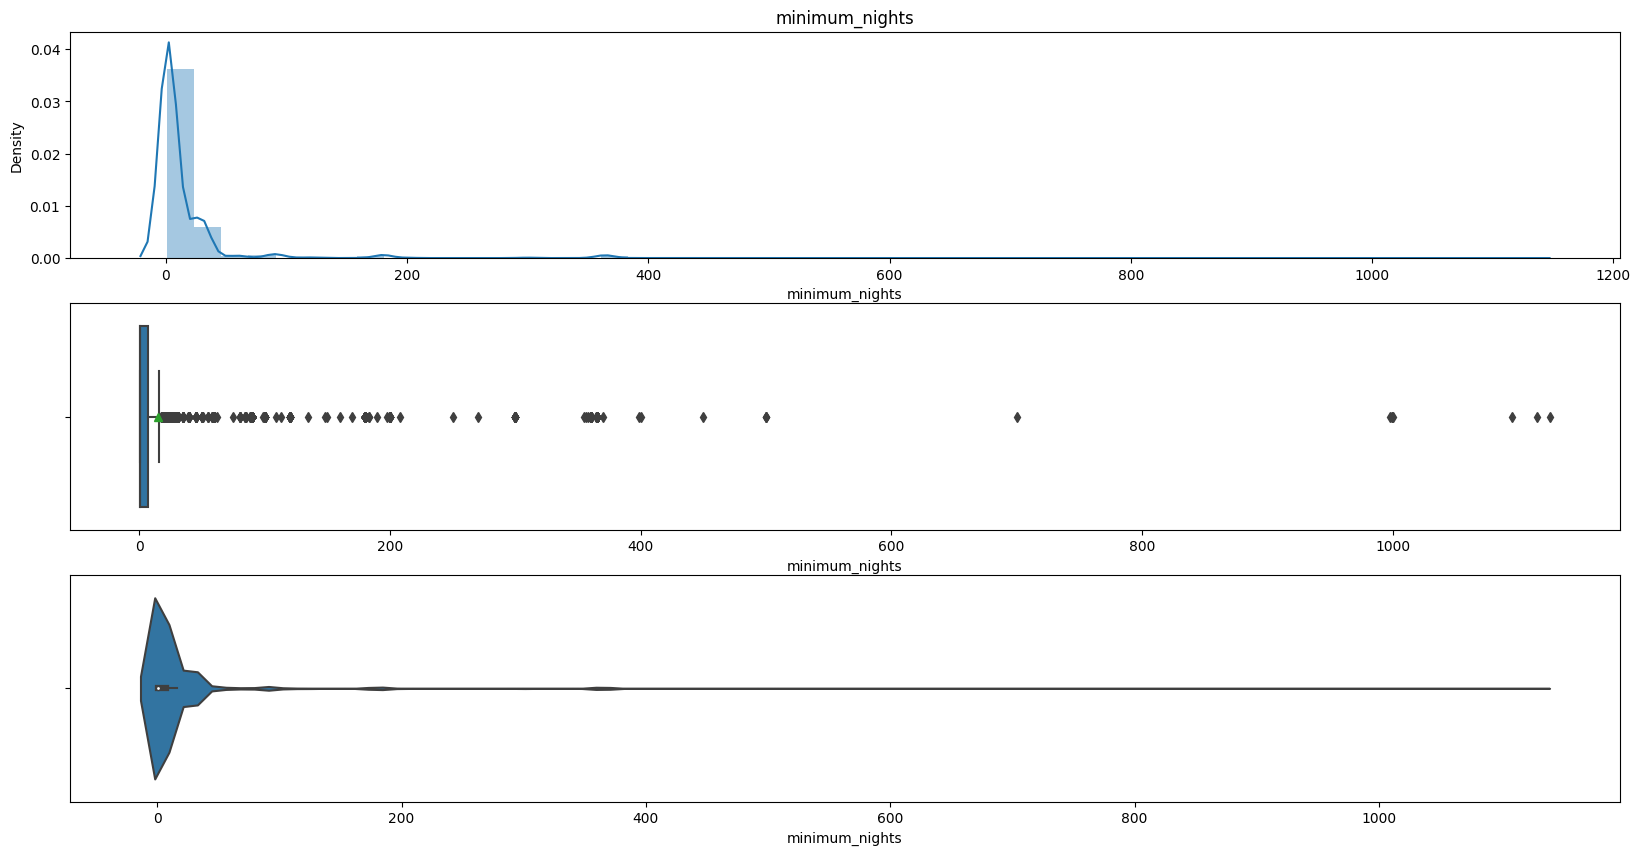

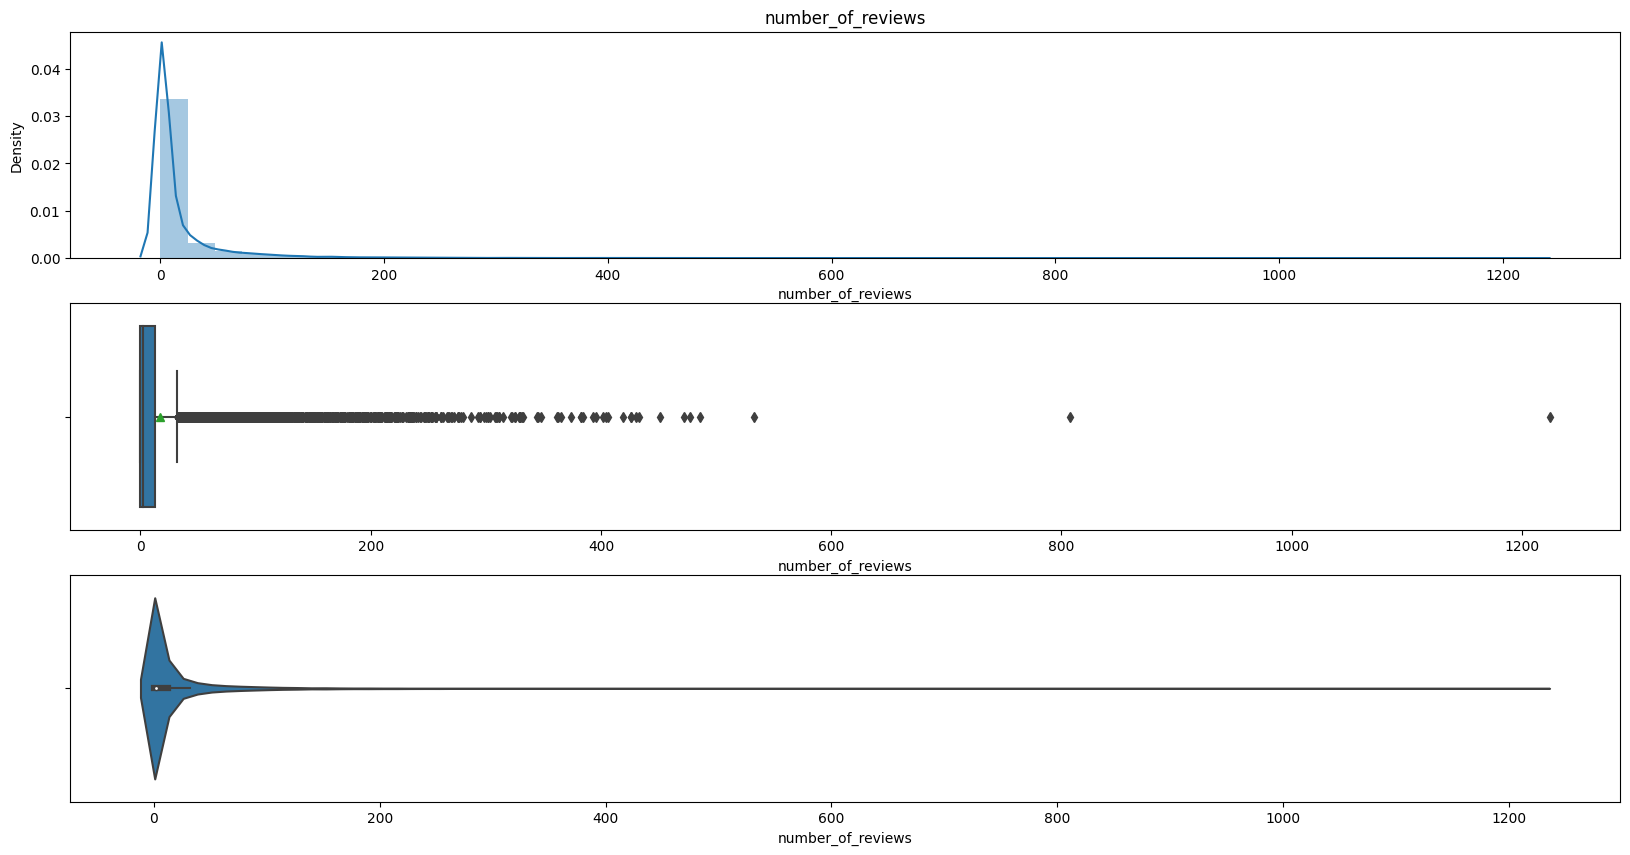

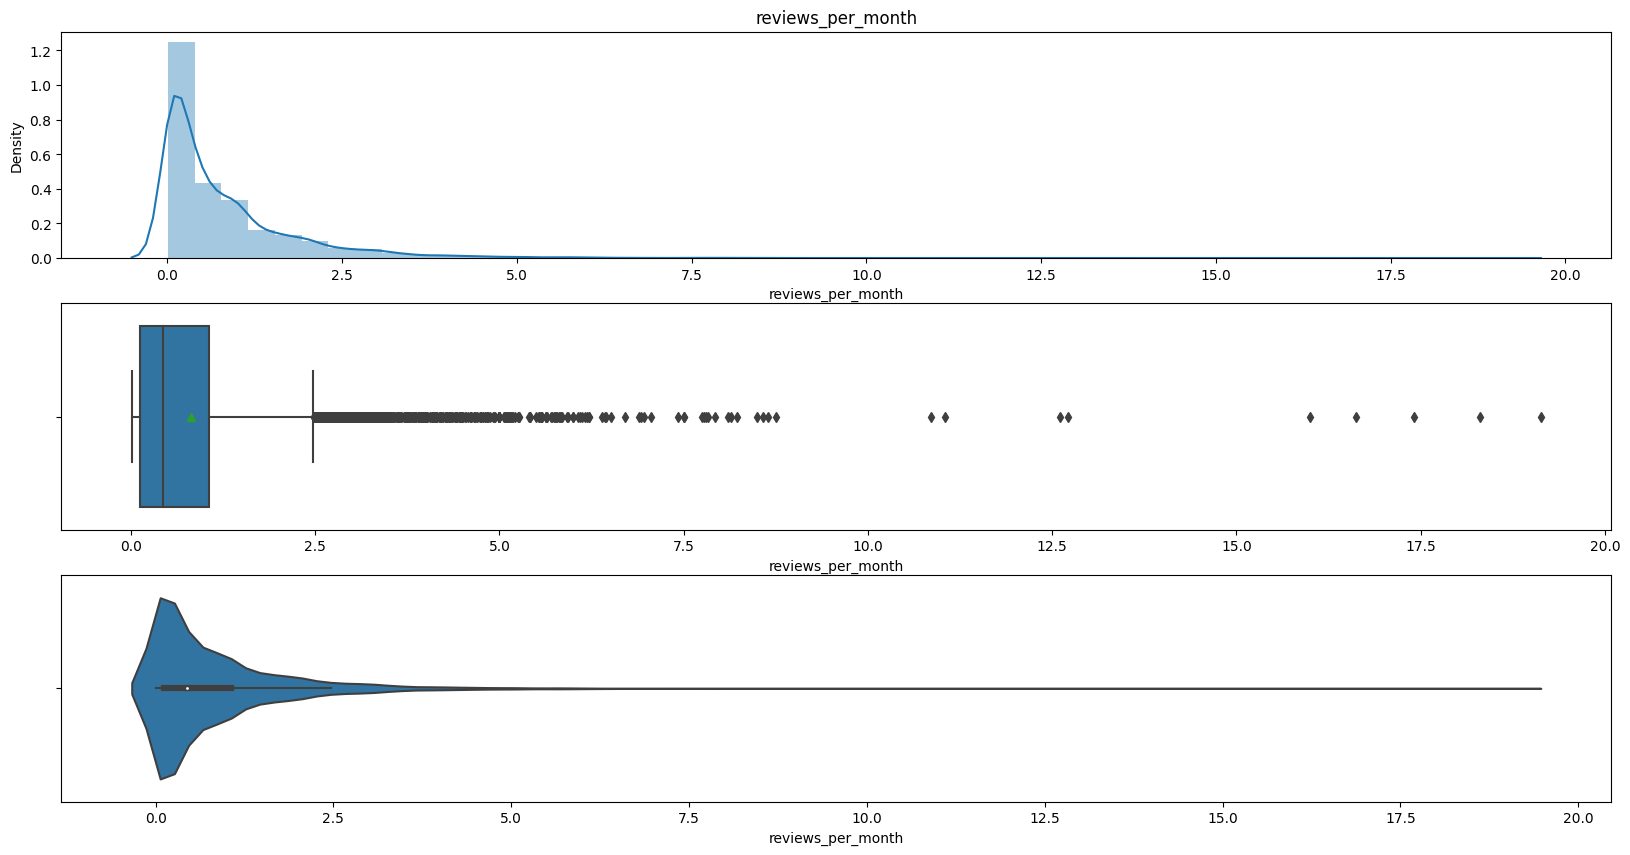

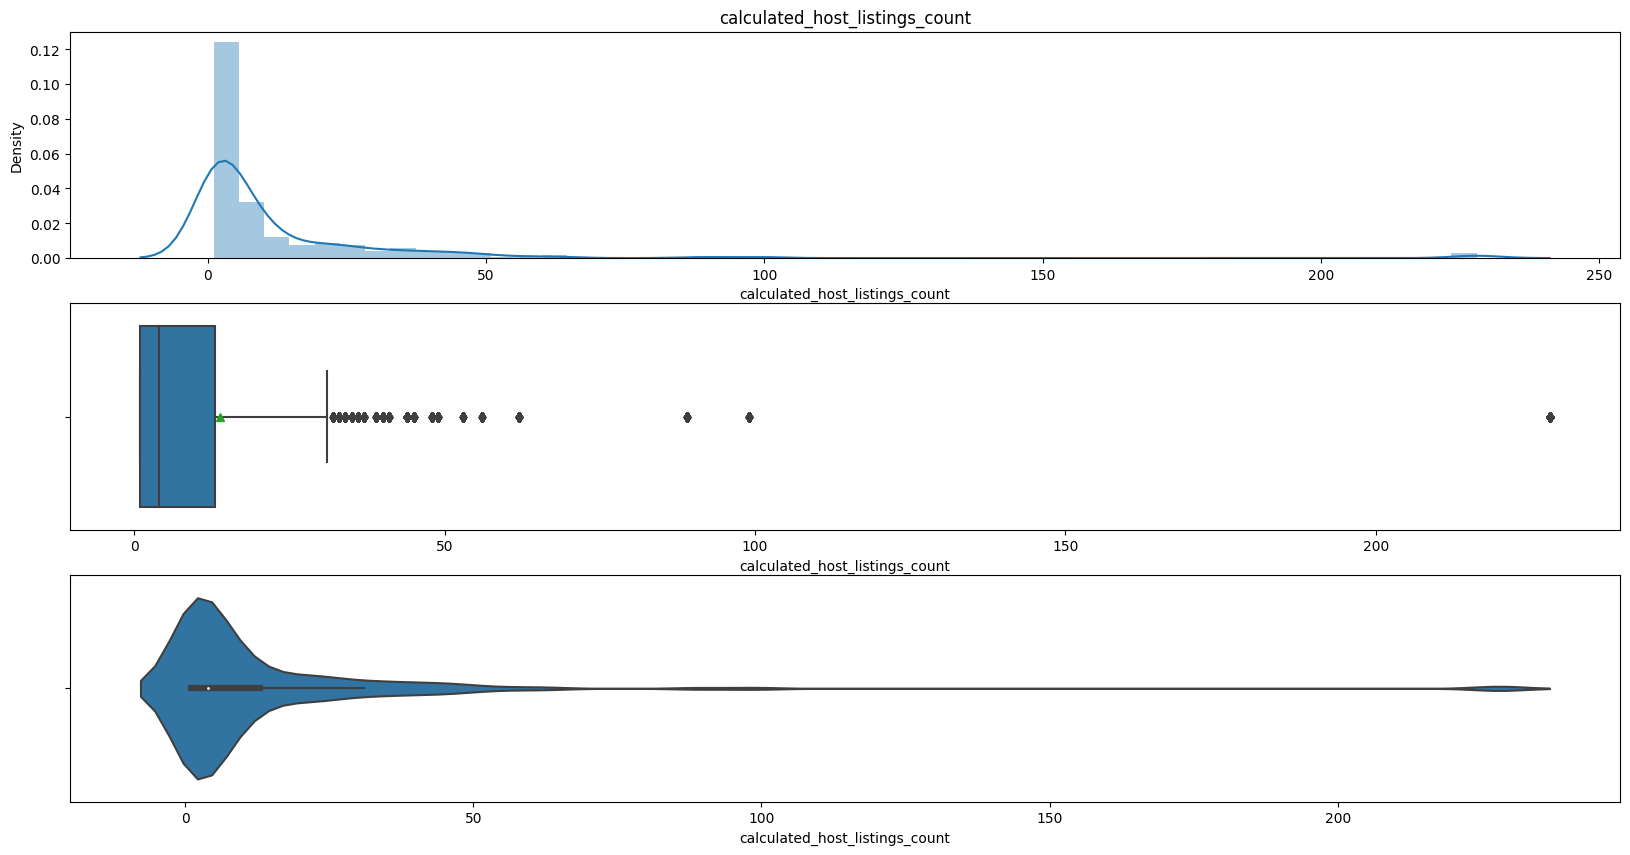

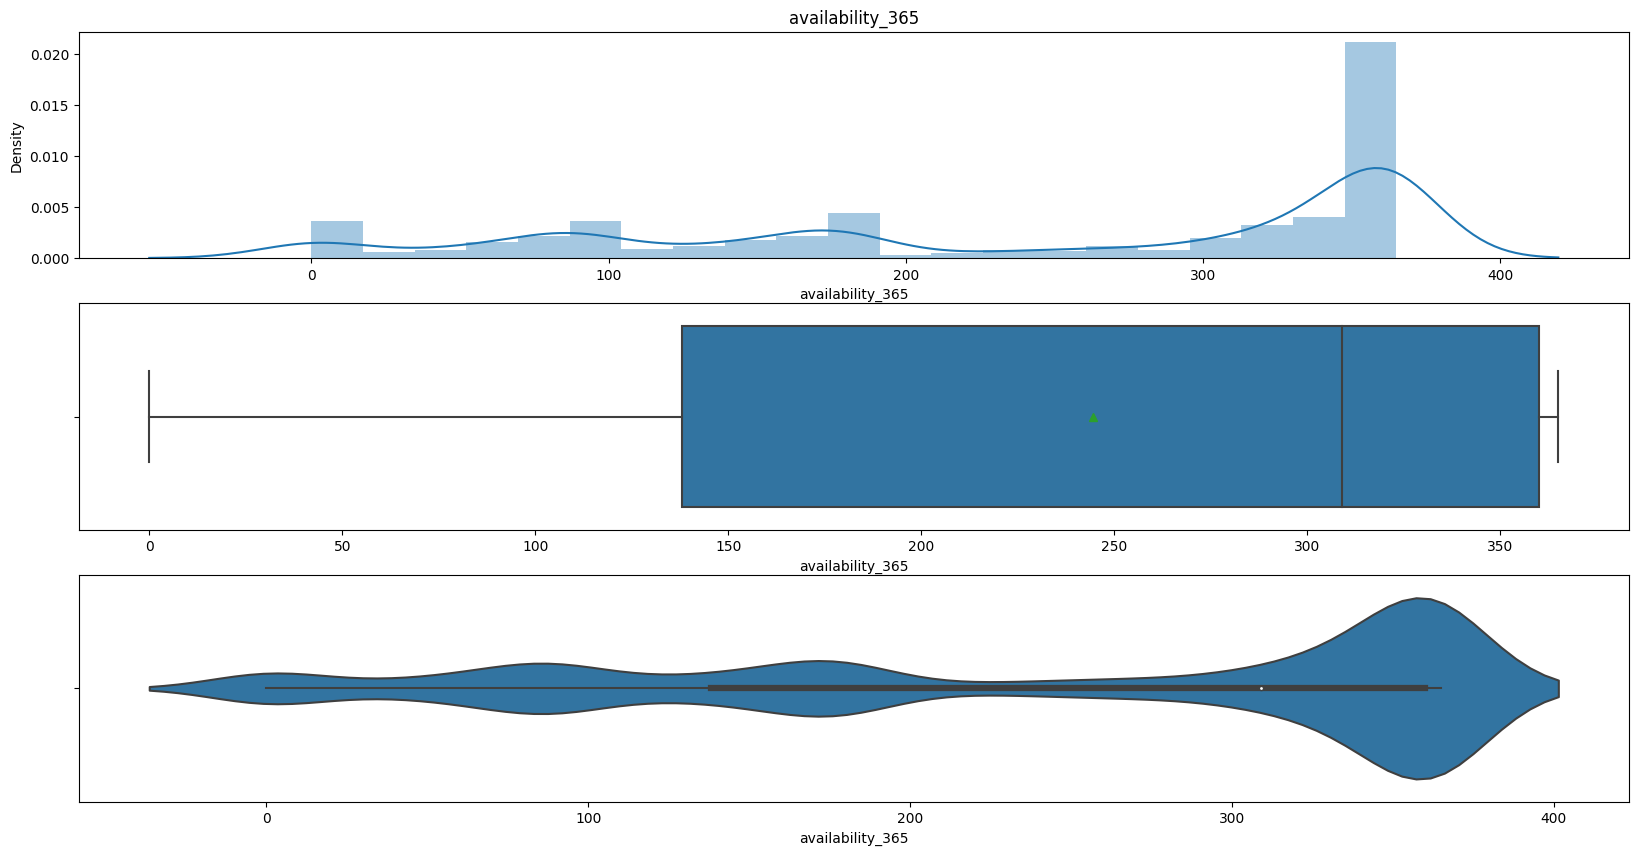

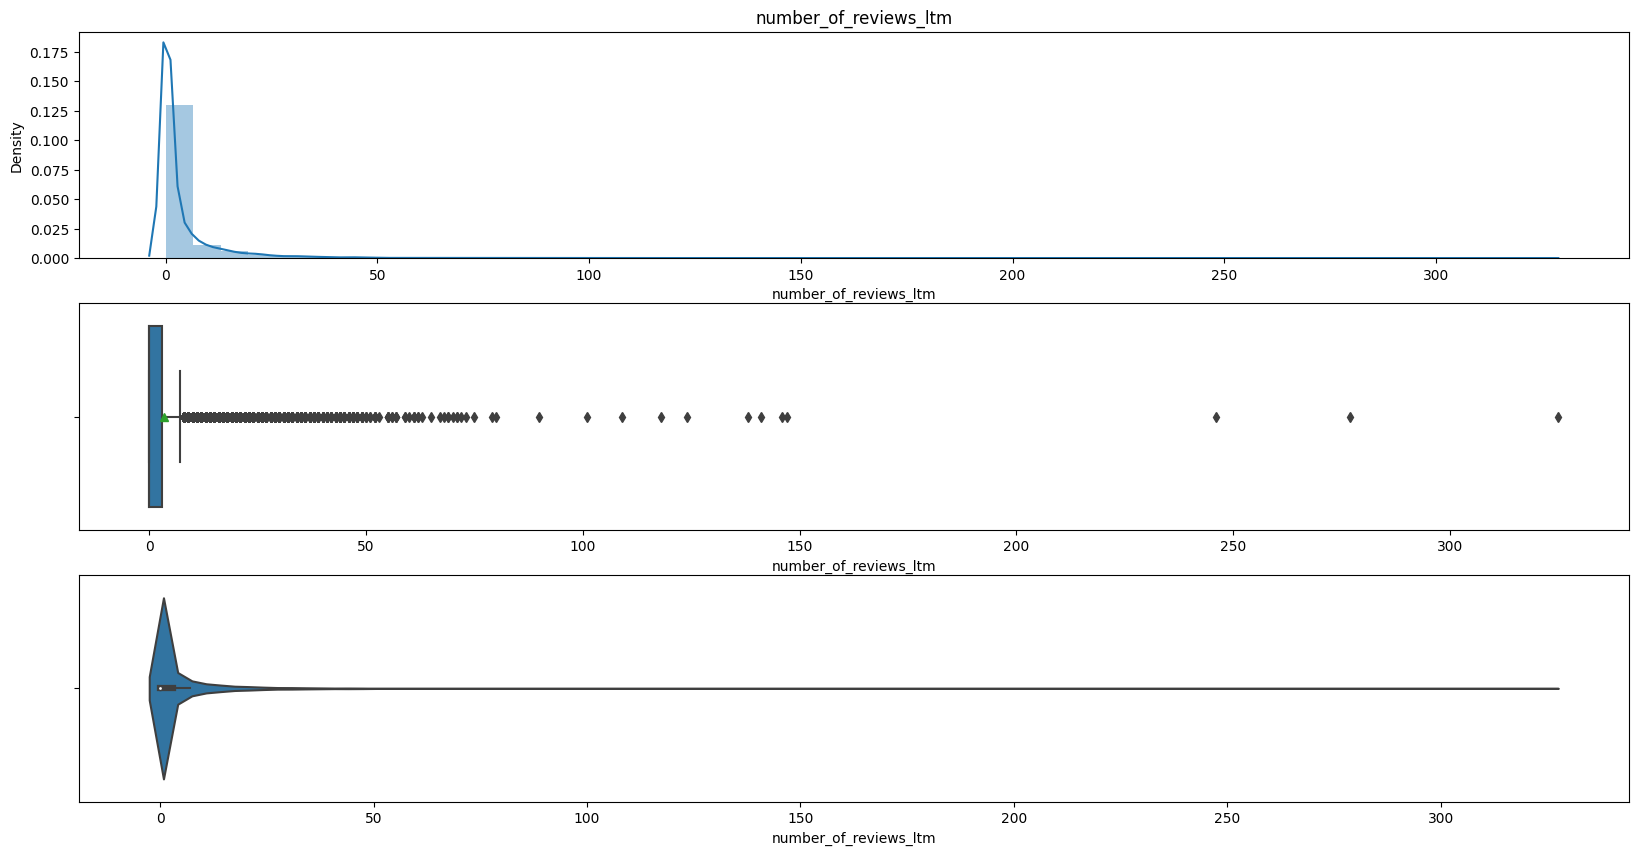

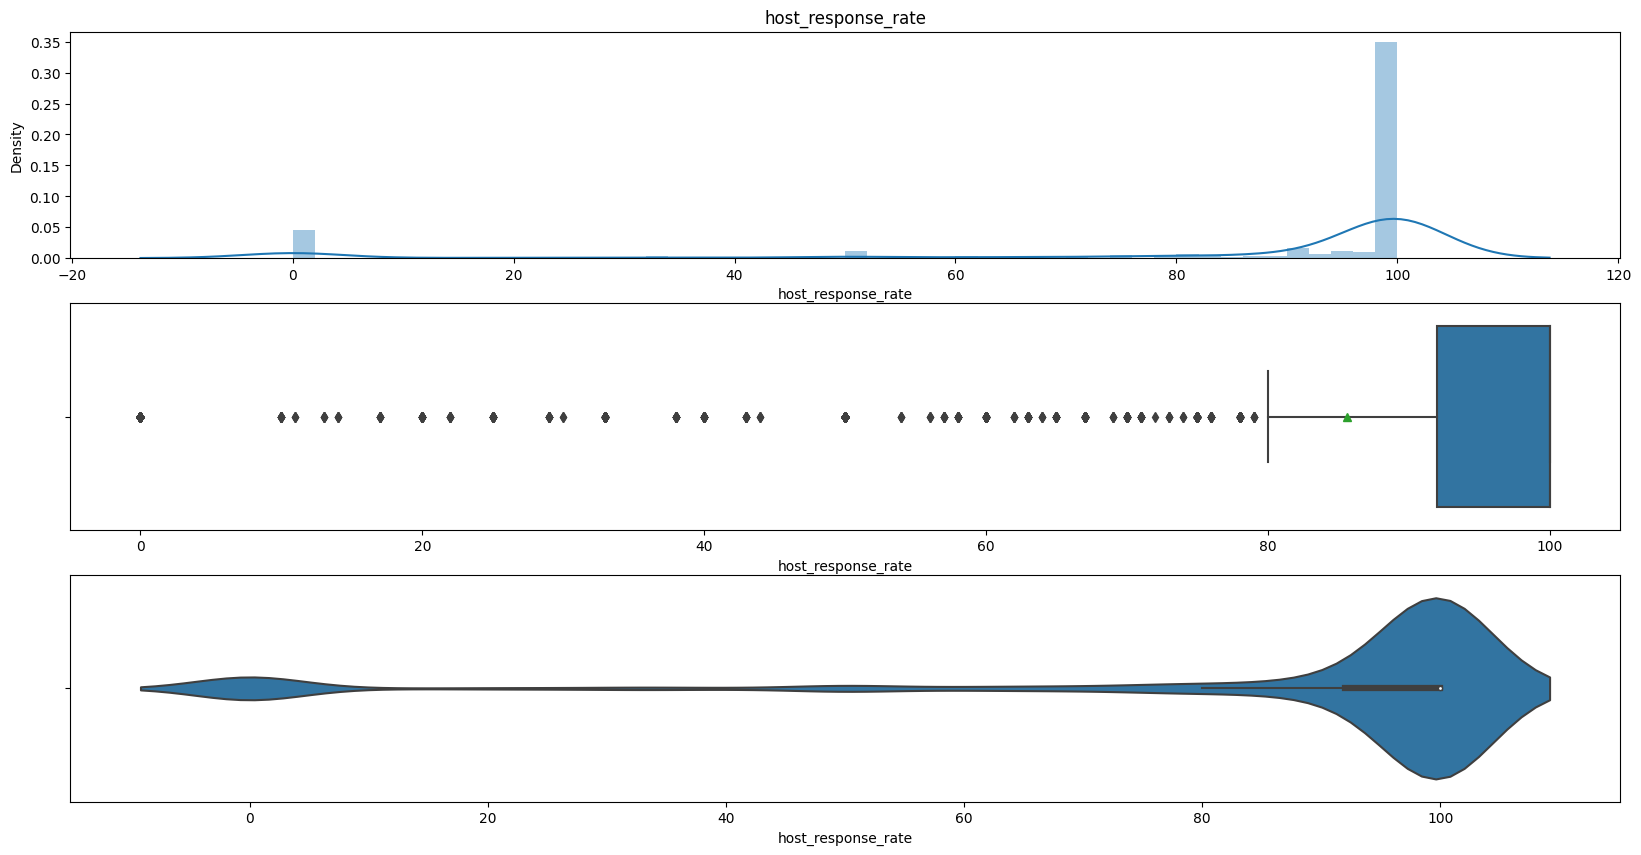

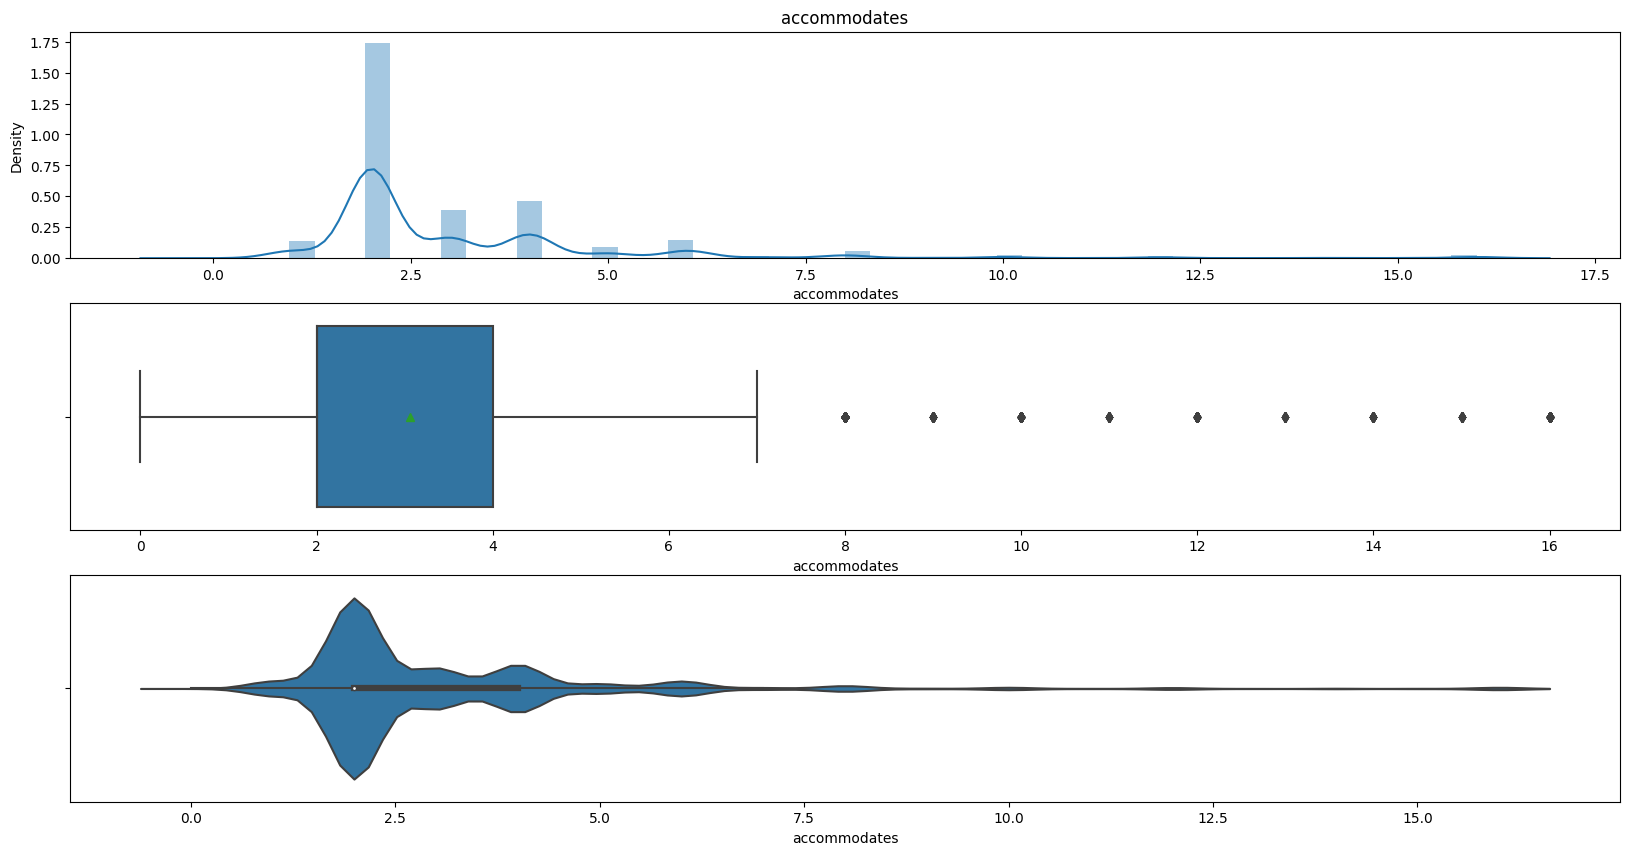

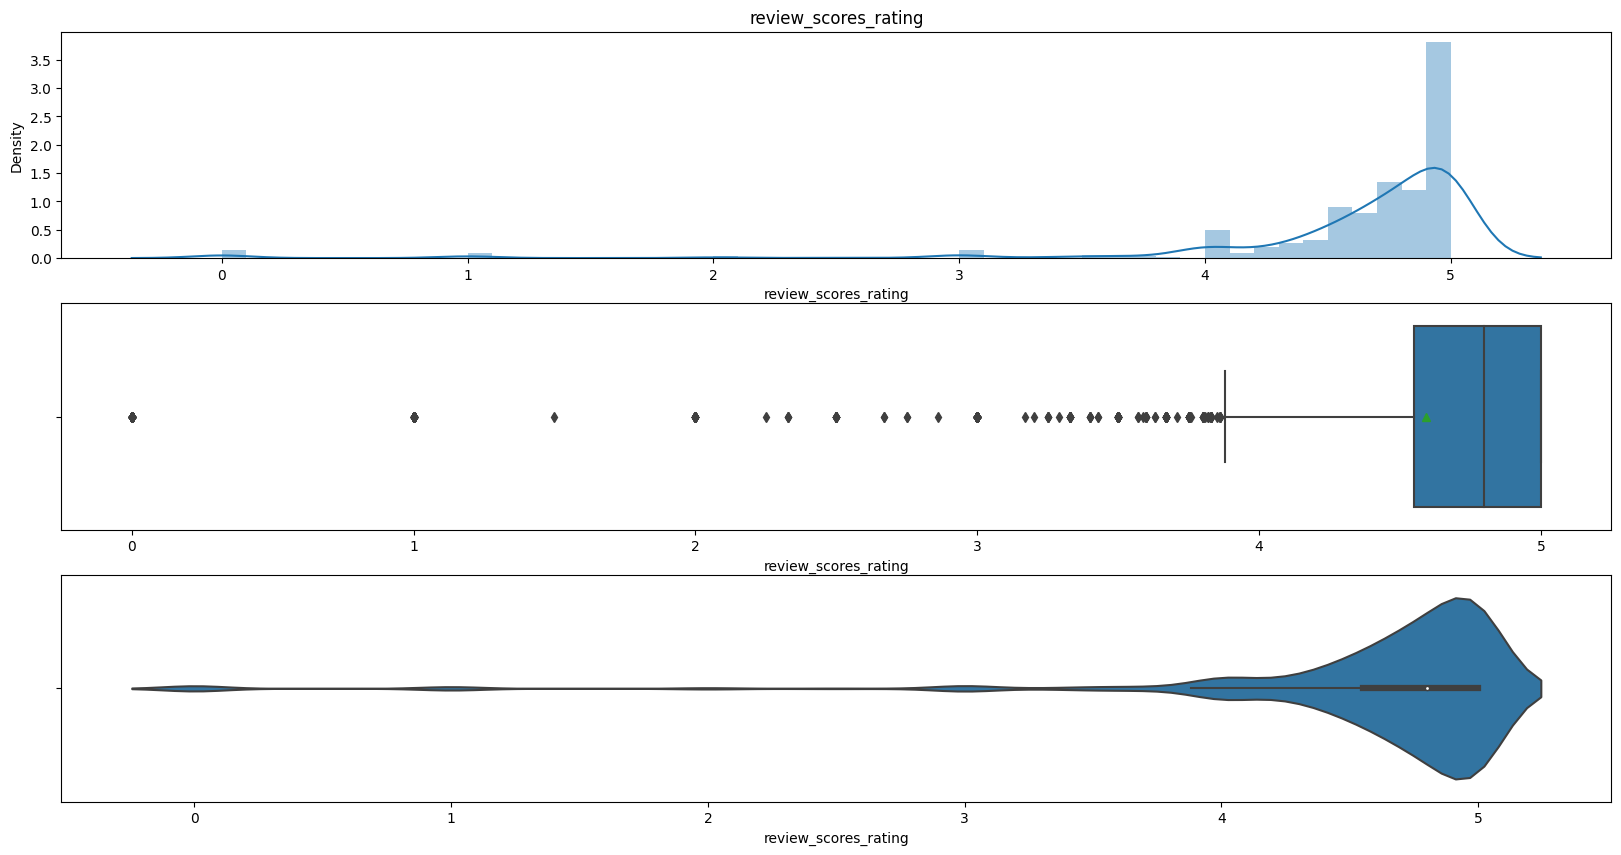

In [12]:
outChck = bnb.select_dtypes(exclude=['object']).iloc[:,3:]

for col in outChck.columns:
    fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(20,10))

    ax[0].set_title(col)
    sns.distplot(outChck[col], ax=ax[0])
    sns.boxplot(x=outChck[col], showmeans=True, ax=ax[1])
    sns.violinplot(x=outChck[col], ax=ax[2])

    plt.show()

### `Insight`

1. This dataset has 15854 rows and 17 columns
2. column `Unnamed 0`: contains index rows values, so it is not relevant for analysis, can be deleted
3. The `last_review` column has a data type that does not match (actual: 'object', expected: 'datetime')
4. There is no duplicate data
5. Missing value is found in column:
    * `last review` (5790 rows / 36.5% of total rows)
    * `reviews_per_month` (5790 rows / 36.5% of total rows), name (8 rows / 0.05% of total rows)
    * `host_name` (1 row / 0.006% of total rows)
6. At a glance, we can see that the missing values in `last_review` and `reviews_per_month` have the same number and distribution.
7. There is a value of 0 in the `price` column
8. In distribution and outliers checking, it was found that:
    * `lattitude` (dist: right skew, outliers: exist, based on the range it is still **reasonable** because it is not far from the value of Bangkok lattitude) 
    * `longtitude` (dist: skew left, outliers: exist, based on the range it is still **reasonable** because it is not far from the value of Bangkok longtitude)
    * `price` (dist: skew right, outlier: exists, based on the range it **does not make sense** because there is a max value of 1,100,000 THB, even though according to domain knowledge the most expensive Airbnb price in Thailand is 835,632 THB)
    * `minimum_nights` (dist: right skew, outlier: exists, based on the range it **doesn't make sense** because there is a max value of 1075, meaning that to rent the lodging you have to stay at least almost 3 years)
    * `number_of_reviews` (dist: skew right, outlier: exists, can be checked more deeply)
    * `calculated_host_listing_count` (dist: right skew, outlier: exists, can be checked further)
    * `availability_365` (dist: left skew, outliers: none, pattern: present)
    * `number_of_reviews_ltm` (dist: skew right, outlier: exists, can be checked more deeply)

## Data Cleaning

### Unnecessary Column

In [13]:
# drop column unnamed
bnb.drop(columns='Unnamed: 0', axis=1, inplace=True)

bnb.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm', 'listing_url', 'host_response_time',
       'host_response_rate', 'accommodates', 'amenities',
       'review_scores_rating', 'accommodates_type'],
      dtype='object')

`handling`

* column `Unnamed_0`: contains index rows values, so it is not relevant for analysis, can be deleted

### Data Type

In [14]:
# convert tipe data last_review
bnb['last_review'] = pd.to_datetime(bnb['last_review'])

display(bnb['last_review'].dtype, bnb['last_review'].min(), bnb['last_review'].max())

dtype('<M8[ns]')

Timestamp('2012-12-15 00:00:00')

Timestamp('2022-12-28 00:00:00')

`handling`
* `last_review` column is a column containing a date but the data type is still an object. Therefore, we change it into datetime data type

### Missing Values

#### last_reviews dan reviews_per_month

In [15]:
# check null values last_review & reviews per month

colRev = list(filter(lambda x: 'review' in x, bnb.columns))
nullRev = bnb[bnb.last_review.isna()][colRev]

pd.DataFrame(
        {
        'feature': nullRev.columns.values,
        'n_unique': nullRev.nunique().values,
        'sample_unique': [nullRev[col].sort_values().unique() for col in nullRev.columns]
        }
    )

,feature,n_unique,sample_unique
0,number_of_reviews,1,[0]
1,last_review,0,[NaT]
2,reviews_per_month,0,[nan]
3,number_of_reviews_ltm,1,[0]
4,review_scores_rating,0,[nan]


In [16]:
# check correlation between all reviews column

revCheck = bnb[colRev].copy()
revCheck = revCheck.fillna(0)
revCheck = revCheck[~(revCheck != 0)].fillna(1).corr()
revCheck

,number_of_reviews,last_review,reviews_per_month,number_of_reviews_ltm,review_scores_rating
number_of_reviews,1.000000,1.000000,1.000000,0.643393,0.981096
last_review,1.000000,1.000000,1.000000,0.643393,0.981096
reviews_per_month,1.000000,1.000000,1.000000,0.643393,0.981096
number_of_reviews_ltm,0.643393,0.643393,0.643393,1.000000,0.654997
review_scores_rating,0.981096,0.981096,0.981096,0.654997,1.000000


<Axes: >

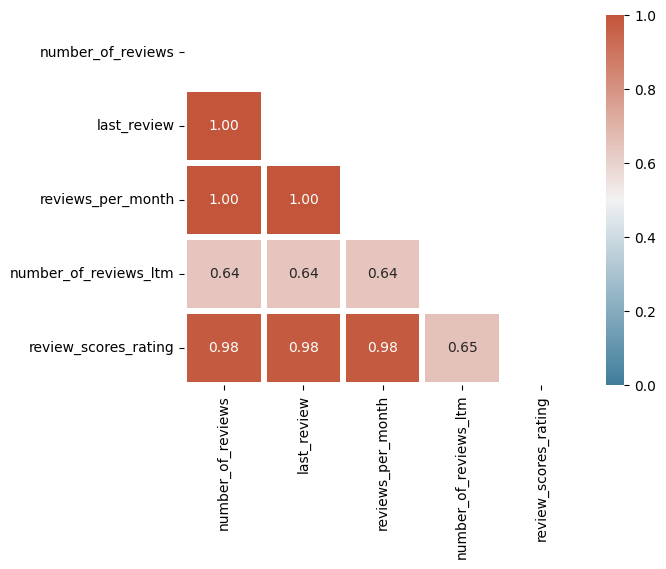

In [17]:
# heatmap correlation between all reviews columns

matrix = np.triu(revCheck)
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(revCheck, annot=True, cmap=cmap, fmt=".2f", vmin=0, vmax=1, mask=matrix, linewidths=3)

In [18]:
# review per month (isi dengan angka 0)

bnb['reviews_per_month'].fillna(0, inplace=True)

In [19]:
# check proporsi missing values

bnb.isna().mean()*100

id                                 0.000000
name                               0.050460
host_id                            0.000000
host_name                          0.006308
neighbourhood                      0.000000
latitude                           0.000000
longitude                          0.000000
room_type                          0.000000
price                              0.000000
minimum_nights                     0.000000
number_of_reviews                  0.000000
last_review                       36.520752
reviews_per_month                  0.000000
calculated_host_listings_count     0.000000
availability_365                   0.000000
number_of_reviews_ltm              0.000000
listing_url                        0.000000
host_response_time                 0.000000
host_response_rate                18.525293
accommodates                       0.000000
amenities                          0.000000
review_scores_rating              36.520752
accommodates_type               

`handling`

* After checking, there is a strong correlation in the missing values from `last_reviews` and `reviews_per_month` columns with the `number_of_reviews` and `number_of_reviews_ltm` columns.
* So, it can be concluded that when the property has no reviews, its `last_reviews` and `reviews_per_month` will be 0.
* Handling missing values that can be done are:
    * `reviews_per_month` = filled with 0
    * `last_review` = let it be null value

#### name dan host_name

In [20]:
# check proporsi missing values

bnb.isna().mean().sort_values(ascending=False)*100

last_review                       36.520752
review_scores_rating              36.520752
host_response_rate                18.525293
name                               0.050460
host_name                          0.006308
calculated_host_listings_count     0.000000
amenities                          0.000000
accommodates                       0.000000
host_response_time                 0.000000
listing_url                        0.000000
number_of_reviews_ltm              0.000000
availability_365                   0.000000
id                                 0.000000
reviews_per_month                  0.000000
number_of_reviews                  0.000000
minimum_nights                     0.000000
price                              0.000000
room_type                          0.000000
longitude                          0.000000
latitude                           0.000000
neighbourhood                      0.000000
host_id                            0.000000
accommodates_type               

In [21]:
# name & host_name
# isi null value dangan string 'no information'

bnb['name'].fillna('no information', inplace=True)
bnb['host_name'].fillna('no information', inplace=True)


In [22]:
# check proporsi missing values

bnb.isna().mean().sort_values(ascending=False)*100

last_review                       36.520752
review_scores_rating              36.520752
host_response_rate                18.525293
reviews_per_month                  0.000000
amenities                          0.000000
accommodates                       0.000000
host_response_time                 0.000000
listing_url                        0.000000
number_of_reviews_ltm              0.000000
availability_365                   0.000000
calculated_host_listings_count     0.000000
id                                 0.000000
name                               0.000000
number_of_reviews                  0.000000
minimum_nights                     0.000000
price                              0.000000
room_type                          0.000000
longitude                          0.000000
latitude                           0.000000
neighbourhood                      0.000000
host_name                          0.000000
host_id                            0.000000
accommodates_type               

`handling`

* The proportion of missing values in `name` and `host_name` is very small (<1%).
* Handling missing values that can be done are:
    * `name` = filled with the string 'no information'
    * `host_name` = filled with the string 'no information'

### Ambiguity

#### price

In [23]:
# price

bnb[bnb.price == 0]

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,listing_url,host_response_time,host_response_rate,accommodates,amenities,review_scores_rating,accommodates_type
11103,44563108,Somerset Maison Asoke Bangkok,360620448,Somerset Maison Asoke,Vadhana,13.73815,100.5642,Hotel room,0,1,0,NaT,0.0,1,0,0,https://www.airbnb.com/rooms/44563108,no information,NaN,0,"[""Bottled water"", ""Kitchen"", ""Limited housekee...",NaN,single/couple


In [24]:
# drop row yang berisi price = 0

bnb.drop(bnb[bnb.price == 0].index, inplace=True)

In [25]:
# check value pada kolom price

bnb.price.sort_values().unique()

array([    278,     280,     295, ..., 1000000, 1014758, 1100000],
      dtype=int64)

`handling`

* There is ambiguity in the `price` column in the form of a value of 0. After checking there is only 1 row that has a price of 0. Therefore, we can drop the row.

### Outliers

Outliers checking is done on numeric variables only. Priority checking is done on columns that **make little sense**

In [26]:
# define prio column to check

numCol = bnb.select_dtypes(exclude=object).columns[2:]

prioCol = ['price', 'minimum_nights']
lessCol = list(filter(lambda x: x not in prioCol, numCol))

display(prioCol, lessCol)


['price', 'minimum_nights']

['latitude',
 'longitude',
 'number_of_reviews',
 'last_review',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365',
 'number_of_reviews_ltm',
 'host_response_rate',
 'accommodates',
 'review_scores_rating']

#### price

Based on domain knowledge, it is known that **the most expensive airbnb price in Thailand is 835,632 THB**.

In [27]:
# check outlier using domain knowledge

maxPrice = 835632 # most expensive airbnb in thailand (data retrieve in November 2022)

display(len(bnb[bnb.price > maxPrice]), len(bnb[bnb.price > maxPrice])/bnb.shape[0]*100)

7

0.044155680312874535

In [28]:
# drop data yang melebihi harga maksimum

bnb.drop(index=bnb[bnb.price > maxPrice].index, inplace=True)

count     15846
mean       2770
std       13026
min         278
5%          500
25%         900
50%        1428
75%        2429
95%        6713
max      710760
Name: price, dtype: int32

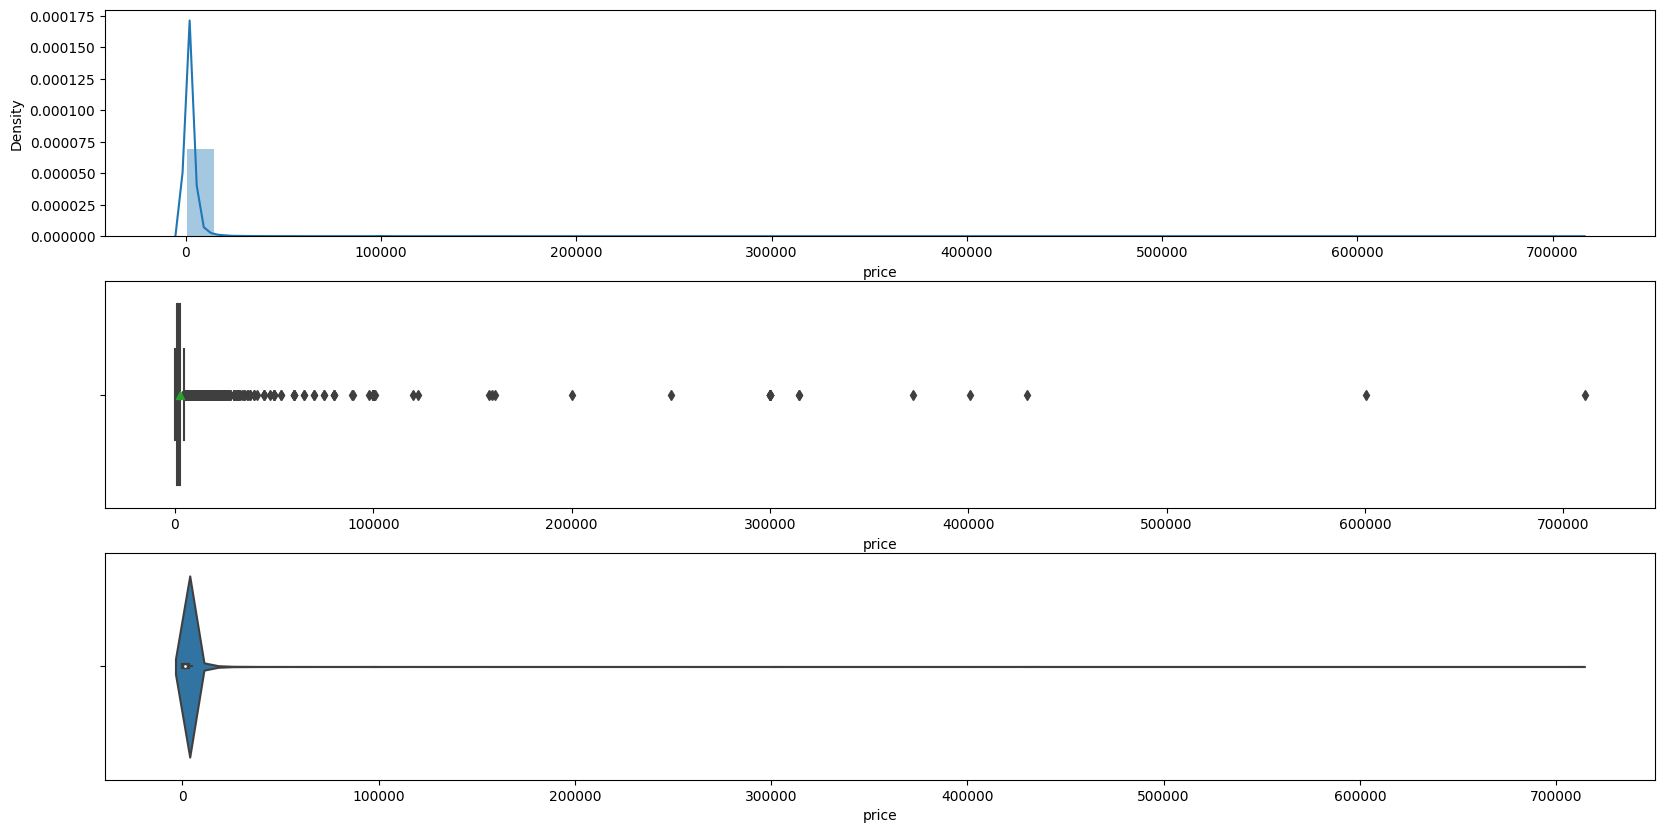

In [29]:
# check the summary & spread

distCheck(bnb['price'])

In [30]:
# check outliers using iqr approach

result = boundLim(bnb, 'price')

print(result[7])


    Hasil pengecekan outlier pada kolom price
    
    lower bound : -1393.5
    upper bound : 4722.5

    jumlah outlier bawah    : 0.0 %
    jumlah outlier atas     : 8.80979426984728 %
    Jumlah semua outlier    : 8.80979426984728 %
    


`handling`

* There are 7 data (0.04% of total rows) whose value > max price in Thailand
* After dropping, in general there are still 8.8% outliers data
* Next Handling is using Discretization

# Feature Engineering

### estimated_bookings_per_month

* Based on domain knowledge, estimated bookings can be converted using the reviews column ([source](http://insideairbnb.com/data-assumptions/))
* In this analysis, the conversion is `reviews_per_month` to `estimated_bookings_per_month`
* `reviews_per_month` was chosen because it is more fair to see the property performance 

In [31]:
# create field estimated booking per month

bnb['estimated_bookings_per_month'] = bnb['reviews_per_month']
bnb.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm', 'listing_url', 'host_response_time',
       'host_response_rate', 'accommodates', 'amenities',
       'review_scores_rating', 'accommodates_type',
       'estimated_bookings_per_month'],
      dtype='object')

### property_performance

* `estimated_bookings_per_month` will be used as the basis for determining property performance 
* The assumptions used are:
    * *high* : listings that have an `estimated_bookings_per_month` value greater than or equal to the upper bound value
    * *low* : listings that have an `estimated_bookings_per_month` value less than the upper bound value

In [32]:
result = boundLim(bnb, 'estimated_bookings_per_month')
print(result[7])


    Hasil pengecekan outlier pada kolom estimated_bookings_per_month
    
    lower bound : -1.0050000000000001
    upper bound : 1.6750000000000003

    jumlah outlier bawah    : 0.0 %
    jumlah outlier atas     : 9.283099835920737 %
    Jumlah semua outlier    : 9.283099835920737 %
    


In [33]:
# convert price

def convertrpm(x):
    if x > result[1]:
        return 'high'
    else:
        return 'low'

bnb['property_performance'] = bnb['estimated_bookings_per_month'].apply(lambda x: convertrpm(x))
bnb['property_performance'].value_counts()

property_performance
low     14375
high     1471
Name: count, dtype: int64

### price_class

In [34]:
# set limit

low, mid, high = round(bnb.price.quantile([1/4,2/4,3/4]),-2)

display(low, mid, high)

900.0

1400.0

2400.0

In [35]:
# convert price

def convertPrice(x):
    if x < low:
        return f'< {low}'
    elif x < mid:
        return f'{low} - {mid}'
    elif x < high:
        return f'{mid} - {high}'
    else:
        return f'> {high}'

bnb['price_class'] = bnb['price'].apply(lambda x: convertPrice(x))
bnb['price_class']

0        1400.0 - 2400.0
1         900.0 - 1400.0
2                < 900.0
3         900.0 - 1400.0
4        1400.0 - 2400.0
5         900.0 - 1400.0
6        1400.0 - 2400.0
7        1400.0 - 2400.0
8        1400.0 - 2400.0
9                < 900.0
10        900.0 - 1400.0
11       1400.0 - 2400.0
12       1400.0 - 2400.0
13        900.0 - 1400.0
14       1400.0 - 2400.0
15              > 2400.0
16       1400.0 - 2400.0
17              > 2400.0
18              > 2400.0
19              > 2400.0
20       1400.0 - 2400.0
21        900.0 - 1400.0
22              > 2400.0
23       1400.0 - 2400.0
24       1400.0 - 2400.0
25       1400.0 - 2400.0
26              > 2400.0
27        900.0 - 1400.0
28        900.0 - 1400.0
29       1400.0 - 2400.0
30        900.0 - 1400.0
31               < 900.0
32       1400.0 - 2400.0
33       1400.0 - 2400.0
34              > 2400.0
35       1400.0 - 2400.0
36        900.0 - 1400.0
37       1400.0 - 2400.0
38              > 2400.0
39       1400.0 - 2400.0


In [36]:
# result price category

bnb['price_class'].value_counts()

price_class
1400.0 - 2400.0    4074
> 2400.0           4048
900.0 - 1400.0     3869
< 900.0            3855
Name: count, dtype: int64

### term_type

using domain knowledge, we can divide listing type by minimum nights to:
* short-terms : <= 30 days
* long-terms : > 30 days

In [37]:
# convert price

def convertNights(x):
    if x <= 30:
        return 'short-terms'
    else:
        return 'long-terms'

bnb['term_type'] = bnb['minimum_nights'].apply(lambda x: convertNights(x))
bnb['term_type'].head()

0    short-terms
1    short-terms
2     long-terms
3    short-terms
4    short-terms
Name: term_type, dtype: object

In [38]:
bnb['term_type'].value_counts()

term_type
short-terms    14980
long-terms       866
Name: count, dtype: int64

# Save Clean Data

In [39]:
bnb.head()

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,listing_url,host_response_time,host_response_rate,accommodates,amenities,review_scores_rating,accommodates_type,estimated_bookings_per_month,property_performance,price_class,term_type
0,27934,Nice room with superb city view,120437,Nuttee,Ratchathewi,13.75983,100.54134,Entire home/apt,1905,3,65,2020-01-06,0.50,2,353,0,https://www.airbnb.com/rooms/27934,within an hour,100.0,3,"[""Shampoo"", ""Kitchen"", ""Fire extinguisher"", ""F...",4.85,family,0.50,low,1400.0 - 2400.0,short-terms
1,27979,"Easy going landlord,easy place",120541,Emy,Bang Na,13.66818,100.61674,Private room,1316,1,0,NaT,0.00,2,358,0,https://www.airbnb.com/rooms/27979,a few days or more,0.0,2,"[""Pool"", ""Washer"", ""First aid kit"", ""Heating"",...",NaN,single/couple,0.00,low,900.0 - 1400.0,short-terms
2,28745,modern-style apartment in Bangkok,123784,Familyroom,Bang Kapi,13.75232,100.62402,Private room,800,60,0,NaT,0.00,1,365,0,https://www.airbnb.com/rooms/28745,no information,NaN,2,"[""Long term stays allowed""]",NaN,single/couple,0.00,low,< 900.0,long-terms
3,35780,Spacious one bedroom at The Kris Condo Bldg. 3,153730,Sirilak,Din Daeng,13.78823,100.57256,Private room,1286,7,2,2022-04-01,0.03,1,323,1,https://www.airbnb.com/rooms/35780,within an hour,100.0,2,"[""Clothing storage: closet and dresser"", ""Blen...",4.50,single/couple,0.03,low,900.0 - 1400.0,short-terms
4,941865,Suite Room 3 at MetroPoint,610315,Kasem,Bang Kapi,13.76872,100.63338,Private room,1905,1,0,NaT,0.00,3,365,0,https://www.airbnb.com/rooms/941865,within an hour,100.0,2,"[""Washer"", ""Air conditioning"", ""Breakfast"", ""K...",NaN,single/couple,0.00,low,1400.0 - 2400.0,short-terms


In [40]:
bnb.to_csv('D:\PURWADHIKA\PLAYGROUND\PYTHON\Modul 2\Capstone\Airbnb-listings-Bangkok\data\processed\cleaned_data.csv', index=False)
bnb.to_excel('D:\PURWADHIKA\PLAYGROUND\PYTHON\Modul 2\Capstone\Airbnb-listings-Bangkok\data\processed\cleaned_data.xlsx', index=False)